# **Import frameworks dan libraries yang diperlukan**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.utils import resample
from keras.layers import SimpleRNN
from keras.models import load_model

import pickle
import json
import re
import pandas as pd
import numpy as np
import tensorflow as tf

import gensim
import seaborn as sns
import matplotlib.pyplot as plt

# **Load dataset, lakukan preprocessing, dan singkronisasi jumlah data.**


In [ ]:
stopwords = open('stopwords_id.txt', 'r').read().splitlines()

def clean_chars(sent):
    url_remove = re.sub(r'http\S+', ' ', sent.lower())
    char_remove = re.sub(r'[^a-zA-Z0-9#@]', ' ', url_remove)
    char_len = [i for i in char_remove.split() if len(i) > 2]
    temp = [i for i in char_len if not i.startswith('#') and not i.startswith('@') and i not in stopwords]
    return ' '.join(temp)

def sync_data(bisnis, sains, sport):
    dict = {'bisnis': len(bisnis), 'sains': len(sains), 'sport': len(sport)}
    lowest = min(dict.items(), key=lambda x: x[1])

    bisnis = resample(bisnis,replace=False, n_samples=lowest[1], random_state=123)
    sains = resample(sains,replace=False, n_samples=lowest[1], random_state=123)
    sport = resample(sport,replace=False, n_samples=lowest[1], random_state=123)

    return bisnis, sains, sport

bisnis = []
sport = []
sains = []

bisnis_label = []
sport_label = []
sains_label = []

with open('news.json') as f:
    data = json.load(f)
    
for d in data:
  if d['kategori'] == 'bisnis':
      content = clean_chars(d['content'])
      bisnis_label.append(d['kategori'])
      bisnis.append(content)

  elif d['kategori'] == 'sains':
      content = clean_chars(d['content'])
      sport_label.append(d['kategori'])
      sport.append(content)

  elif d['kategori'] == 'sport':
      content = clean_chars(d['content'])
      sains_label.append(d['kategori'])
      sains.append(content)
      
bisnis, sains, sport = sync_data(bisnis, sains, sport)

print("bisnis: %s, sains: %s, sport: %s" % (len(bisnis), len(sains), len(sport)))

statuses = bisnis + sains + sport

print("Total data: %s" % len(statuses))

bisnis_label, sains_label, sport_label = sync_data(bisnis_label, sains_label, sport_label)

labels = bisnis_label + sains_label + sport_label

bisnis: 500, sains: 500, sport: 500
Total data: 1500


# **Ubah data menjadi embedding**

In [ ]:
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(statuses)

X = tokenizer.texts_to_sequences(statuses)
X = pad_sequences(X)

Y = pd.get_dummies(labels).values

print(X)
print(Y)

[[   0    0    0 ... 1546  463  302]
 [   0    0    0 ...   57  538  537]
 [   0    0    0 ... 1447 1549  883]
 ...
 [   0    0    0 ...    2 1520 2795]
 [   0    0    0 ...   85   16  281]
 [   0    0    0 ... 1925  985  451]]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [0 1 0]
 [0 1 0]]


# **Split data menjadi data training, testing, valid**



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# **Create Model**

In [ ]:
max_features = 3000
embed_dim = 128
units = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(units, dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())


batch_size = 1000
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)

score, accuracy = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=1)
print("score: ", score)
print("accuracy: ", accuracy)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 312, 128)          384000    
                                                                 
 lstm_8 (LSTM)               (None, 196)               254800    
                                                                 
 dense_8 (Dense)             (None, 3)                 591       
                                                                 
Total params: 639,391
Trainable params: 639,391
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 0.6934 - accuracy: 0.3073 - val_loss: 0.6902 - val_accuracy: 0.5100
Epoch 2/10
1/1 [==============================] - 0s 261ms/step - loss: 0.6898 - accuracy: 0.5427 - val_loss: 0.6867 - val_accuracy: 0.6267
Epoch 3/10
1/1 [==============

# **Visualisasi**

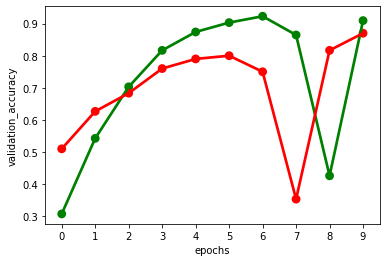

In [ ]:
df = pd.DataFrame({'epochs':history.epoch, 'accuracy': history.history['accuracy'], 'validation_accuracy': history.history['val_accuracy']})
g = sns.pointplot(x="epochs", y="accuracy", data=df, fit_reg=False, color='green')
g = sns.pointplot(x="epochs", y="validation_accuracy", data=df, fit_reg=False, color='red')

# **Save model**

In [ ]:
model.save('klasifikasi-berita.h5')
print("Model has created!")

Model has created!


# **Predict data**

In [ ]:
input_text = """Legenda MotoGP, Jorge Lorenzo menerangkan perbedaan dari dua pembalap sangar, Valentino Rossi dan Marc Marquez.Mantan rekan setim Valentino Rossi 
itu tentu paham betul bagaimana aksi The Doctor saat menggeber kuda besinya di lintasan balap.Sementara itu dari kacamata Lorenzo, dia juga bisa menilai Marc Marquez 
salah satu rider MotoGP terbaik pula.Akan tetapi tetap saja dari dua pembalap yang bersinar di MotoGP tersebut ada sebuah perbedaan yang memang bagi Lorenzo cukup mencolok.
Bagi pria berpaspor Spanyol itu menuturkan bahwa Valentino Rossi adalah pembalap yang cukup pandai dalam berimproviasai.Rider yang identik dengan nomor #46 itu bisa menerka 
situasi dalam balapan sehingga bisa melakukan perubahan di tengah race.Hal itu yang menurut Lorenzo jadi keistimewaan dari legenda MotoGP asal Italia itu."Rossi sangat cerdas, 
dia tahu bagaimana berimprovisasi dengan sangat baik dalam setiap situasi selama balapan. Menang secara tatap muka sangat sulit," tutur Lorenzo dilansir Motosan.
"""

text = [clean_chars(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('klasifikasi-berita.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

kategori = ['bisnis', 'sains', 'olahraga']

print("Text: ",input_text)
print("Kategori: ",kategori[polarity])

1/1 [==============================] - 0s 390ms/step
Text:  Legenda MotoGP, Jorge Lorenzo menerangkan perbedaan dari dua pembalap sangar, Valentino Rossi dan Marc Marquez.Mantan rekan setim Valentino Rossi 
itu tentu paham betul bagaimana aksi The Doctor saat menggeber kuda besinya di lintasan balap.Sementara itu dari kacamata Lorenzo, dia juga bisa menilai Marc Marquez 
salah satu rider MotoGP terbaik pula.Akan tetapi tetap saja dari dua pembalap yang bersinar di MotoGP tersebut ada sebuah perbedaan yang memang bagi Lorenzo cukup mencolok.
Bagi pria berpaspor Spanyol itu menuturkan bahwa Valentino Rossi adalah pembalap yang cukup pandai dalam berimproviasai.Rider yang identik dengan nomor #46 itu bisa menerka 
situasi dalam balapan sehingga bisa melakukan perubahan di tengah race.Hal itu yang menurut Lorenzo jadi keistimewaan dari legenda MotoGP asal Italia itu."Rossi sangat cerdas, 
dia tahu bagaimana berimprovisasi dengan sangat baik dalam setiap situasi selama balapan. Menang secar